In this notebook, we will optimize the prompts directly to increase FLIPD. Use the following block to specify your prompt and parameters:

In [1]:
prompt = "Air Conditioners & Parts"
seed = 0
num_inference_steps = 50
guidance_scale = 7.5
num_images_per_prompt = 4
image_size = 512

In [2]:
import torch
import mediapy as media
from diffusers import DDIMScheduler
import os

try:
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *
except ModuleNotFoundError:
    import os; os.chdir("..")
    from local_sd_pipeline import LocalStableDiffusionPipeline
    from optim_utils import *

%load_ext autoreload
%autoreload 2

/home/hamid/miniforge3/envs/geometric_diffusion_memorization/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load model
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

model_id = "CompVis/stable-diffusion-v1-4"

pipe = LocalStableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    safety_checker=None,
    requires_safety_checker=False,
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
print(device)
pipe = pipe.to(device)

/home/hamid/miniforge3/envs/geometric_diffusion_memorization/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 10.66it/s]


cuda:1


## Before Optimization

Here is 4 different generations of the diffusion model without any change to the prompt.

100%|██████████| 50/50 [00:03<00:00, 13.24it/s]


prompt: Air Conditioners & Parts



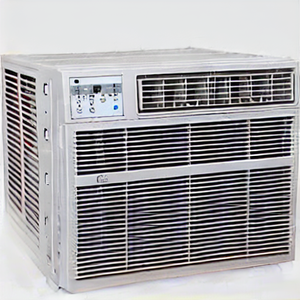
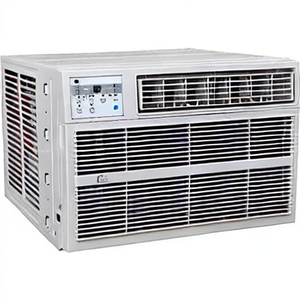
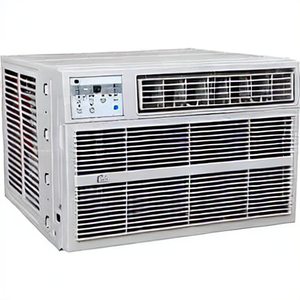
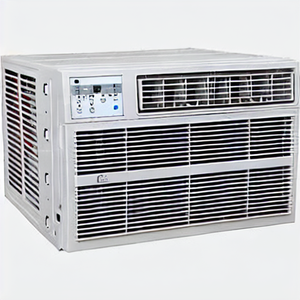

In [4]:
set_random_seed(seed)

outputs, track_stats = pipe(
    prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    track_noise_norm=True,
)
outputs = outputs.images

print(f"prompt: {prompt}")
media.show_images(outputs, width=300)

## After Optimizing the Prompt to Increase FLIPD

Here we optimize the prompt to increase FLIPD (mirroring the results from Figure 9 of [the paper](https://arxiv.org/pdf/2411.00113)). As you can see, when the prompt is optimized, the generated images seem more and more chaotic, until they converge to images with many textures and artificially high intrinsic dimensionality. 

100%|██████████| 50/50 [00:03<00:00, 13.34it/s]



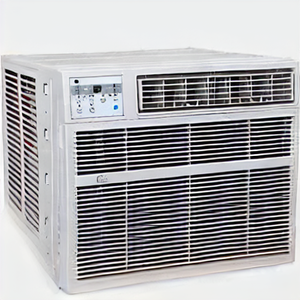
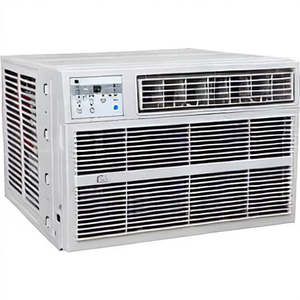
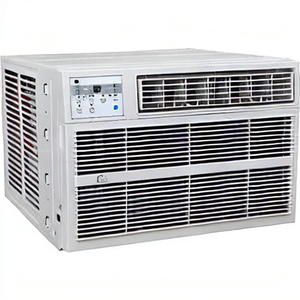
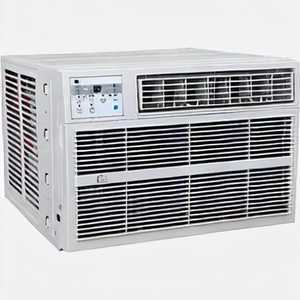

100%|██████████| 50/50 [00:03<00:00, 13.10it/s]



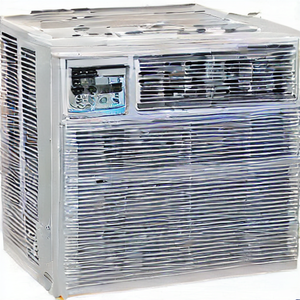
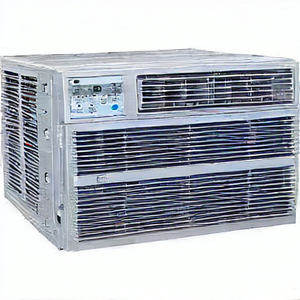
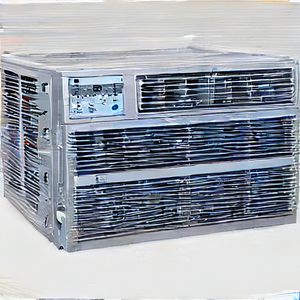
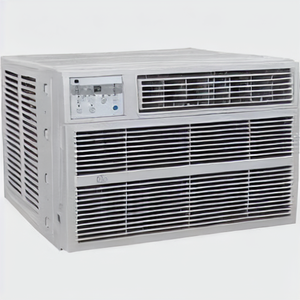

100%|██████████| 50/50 [00:03<00:00, 12.73it/s]



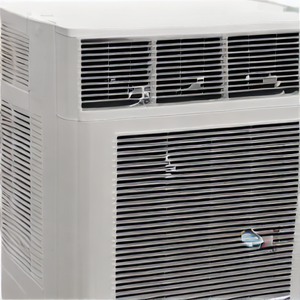
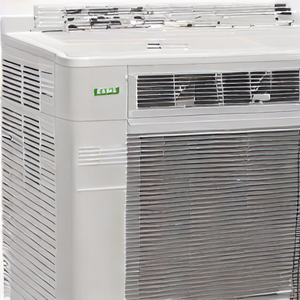
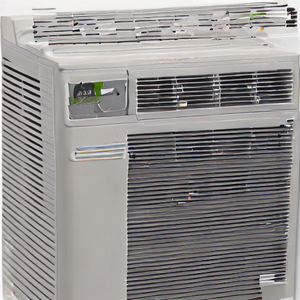
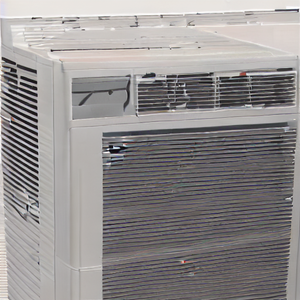

100%|██████████| 50/50 [00:04<00:00, 12.35it/s]



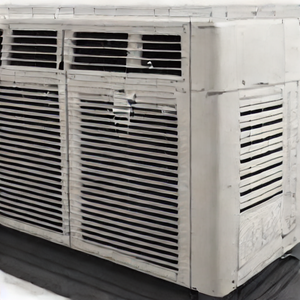
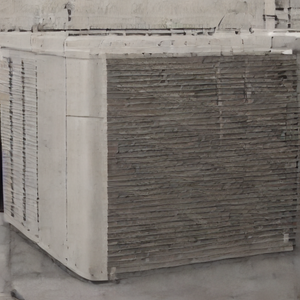
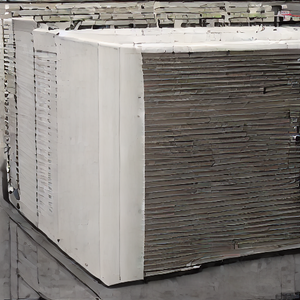
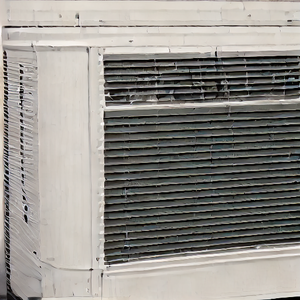

100%|██████████| 50/50 [00:04<00:00, 12.15it/s]



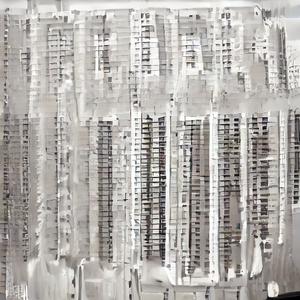
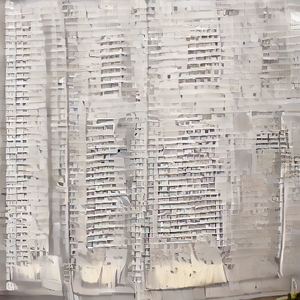
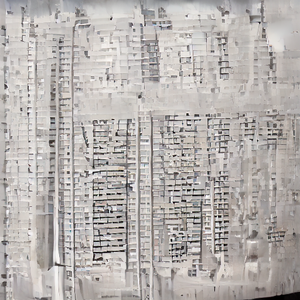
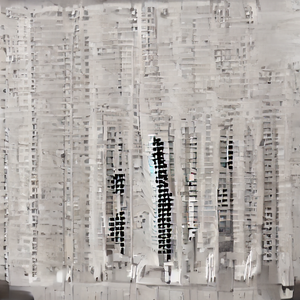

In [8]:
method = "flipd"
for num_steps in [1, 5, 10, 20, 25]:
    auged_prompt_embeds = pipe.aug_prompt(
        prompt,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        num_images_per_prompt=1 if method == "flipd" else num_images_per_prompt,
        target_steps=[40],
        lr=0.05,
        optim_iters=num_steps,
        print_optim=True,
        method=method,
    )
    set_random_seed(seed)

    outputs, track_stats = pipe(
        prompt_embeds=auged_prompt_embeds,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        num_images_per_prompt=num_images_per_prompt,
        track_noise_norm=True,
        height=image_size,
        width=image_size,
    )
    outputs = outputs.images
    media.show_images(outputs, width=300)
